Name = Mahyar Jahani nasab

STD = 401210129

In [1]:
!wget http://images.cocodataset.org/zips/train2017.zip

--2023-05-04 10:48:00--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.162.121, 54.231.141.9, 54.231.135.97, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.162.121|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  13.3MB/s    in 24m 2s  

2023-05-04 11:12:02 (12.8 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [1]:
!pip install evaluate
!pip install bert_score 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 8.6 MB/s eta 0:0

In [2]:
!unzip train2017.zip


Streaming output truncated to the last 5000 lines.
 extracting: train2017/000000259556.jpg  
 extracting: train2017/000000381931.jpg  
 extracting: train2017/000000569592.jpg  
 extracting: train2017/000000229396.jpg  
 extracting: train2017/000000488990.jpg  
 extracting: train2017/000000348684.jpg  
 extracting: train2017/000000234031.jpg  
 extracting: train2017/000000563584.jpg  
 extracting: train2017/000000276069.jpg  
 extracting: train2017/000000401194.jpg  
 extracting: train2017/000000502089.jpg  
 extracting: train2017/000000192183.jpg  
 extracting: train2017/000000425127.jpg  
 extracting: train2017/000000126766.jpg  
 extracting: train2017/000000324161.jpg  
 extracting: train2017/000000452746.jpg  
 extracting: train2017/000000423782.jpg  
 extracting: train2017/000000546343.jpg  
 extracting: train2017/000000249290.jpg  
 extracting: train2017/000000025529.jpg  
 extracting: train2017/000000316928.jpg  
 extracting: train2017/000000337866.jpg  
 extracting: train2017/00

In [2]:
!pip install pycocotools
!pip install transformers


from PIL import Image
import matplotlib.pyplot as plt
import random

import numpy as np
from tqdm import tqdm
import os
import requests
import skimage.io as io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import  transforms
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator
from transformers import ViTImageProcessor,   GPT2Tokenizer

from pycocotools.coco import COCO

%matplotlib inline


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
dataset_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
target_file = "annotations_trainval2017.zip"
if not os.path.exists(target_file):
    response = requests.get(dataset_url, stream=True)
    with open(target_file, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

# Extract the annotations file
annotations_file = "annotations/captions_train2017.json"
if not os.path.exists(annotations_file):
    !unzip annotations_trainval2017.zip annotations/captions_train2017.json -d .

# Load the COCO dataset using pycocotools
from pycocotools.coco import COCO
coco_caps = COCO(annotations_file)


loading annotations into memory...
Done (t=1.17s)
creating index...
index created!


In [4]:
# Download the COCO dataset
dataset_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
target_file = "annotations_trainval2017.zip"
if not os.path.exists(target_file):
    response = requests.get(dataset_url, stream=True)
    with open(target_file, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

# Extract the annotations file
annotations_file = "annotations/instances_train2017.json"
if not os.path.exists(annotations_file):
    !unzip annotations_trainval2017.zip annotations/instances_train2017.json -d .

# Load the COCO dataset using pycocotools
from pycocotools.coco import COCO
coco = COCO(annotations_file)



loading annotations into memory...
Done (t=37.03s)
creating index...
index created!


http://images.cocodataset.org/train2017/000000144580.jpg
(427, 640, 3)


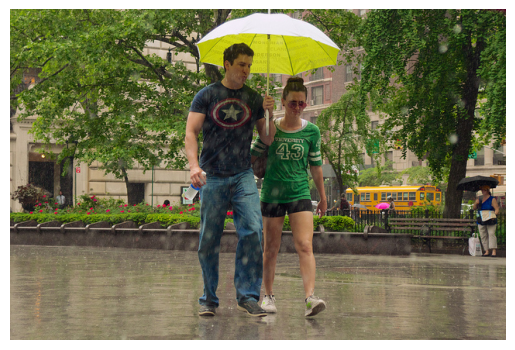

The young couple is walking in the rain with their umbrella up. 
Two people holding an umbrella in the rain
A man and a woman sharing a yellow umbrella in the rain.
Man and woman with umbrella walking on a rainy day.
A man and a woman walking under an umbrella on a sidewalk.


In [5]:
ids = list(coco.anns.keys())
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

print(url)
I = io.imread(url)
print(I.shape)
plt.axis('off')
plt.imshow(I)
plt.show()

annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [7]:
list_of_images = []
random_caps = []
ids = list(coco.anns.keys())
folder_path = "train2017"
import numpy as np
from tqdm import tqdm
for i in tqdm(range(1800)):
    # Download n random pics from the COCO dataset and save them in a list
    ann_id = np.random.choice(ids)
    img_id = coco.anns[ann_id]['image_id']
    img = coco.loadImgs(img_id)[0]
    url = img['coco_url']
    image = Image.open(os.path.join(folder_path, url[40:]))
    if image.mode != 'RGB':
      image = image.convert('RGB')
    image_array = np.array(image) 
    list_of_images.append(image_array)
    annIds = coco_caps.getAnnIds(imgIds=img['id'])
    anns = coco_caps.loadAnns(annIds)
    all_captions = []
    # Select a random related caption for each pic
    for caption in anns:
        all_captions.append(caption['caption'])
    idx_c = np.arange(len(all_captions))
    cap_rand = np.random.choice(idx_c)
    random_caps.append(all_captions[cap_rand])

100%|██████████| 1800/1800 [07:24<00:00,  4.05it/s]


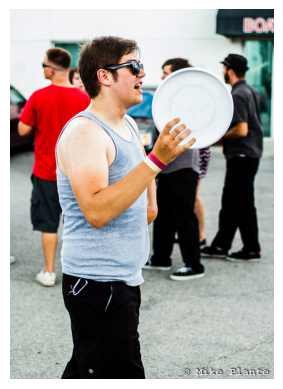

a man holding a frisbee and walking down a street


In [8]:
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(list_of_images[0])
plt.show()
print(random_caps[0])

In [9]:
VIT_MODEL = "google/vit-base-patch16-224-in21k"
DISTIL_GPT2 = 'distilgpt2'



In [10]:
from transformers import ViTImageProcessor, VisionEncoderDecoderModel,  GPT2Tokenizer,ViTFeatureExtractor,AutoTokenizer

feature_extractor = ViTFeatureExtractor.from_pretrained(VIT_MODEL)
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(VIT_MODEL, DISTIL_GPT2, tie_encoder_decoder=True).to('cuda')
gpt2_tokenizer = AutoTokenizer.from_pretrained(DISTIL_GPT2)
gpt2_tokenizer.pad_token = gpt2_tokenizer.unk_token
model.config.eos_token_id = gpt2_tokenizer.eos_token_id
model.config.decoder_start_token_id = gpt2_tokenizer.bos_token_id
model.config.pad_token_id = gpt2_tokenizer.pad_token_id

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.4.crossattention.q_attn.weight', 'transformer.h.3.crossattention.q_attn.weight', 'transformer.h.2.crossattention.c_attn.weight', 'transformer.h.5.crossattention.q_attn.weight', 'transformer.h.4.crossattention.c_proj.weight', 'transformer.h.2.crossattention.q_attn.weight', 'transformer.h.4.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.5.crossattention.c_proj.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.3.crossattention.bias', 'transformer.h.2.crossattention.bias', 'transformer.h.5.

In [11]:
max_len_ = []
for le in random_caps:
  max_len_.append(len(le))
max_len = max(max_len_)

In [12]:
batch_1_x = feature_extractor(do_resize=True,do_normalize=True,images=list_of_images[:1500], return_tensors="pt").pixel_values.to('cuda')
batch_1_y = gpt2_tokenizer(random_caps[:1500], return_tensors='pt', truncation = True,padding="max_length",max_length=max_len).input_ids.to('cuda')
test_x = feature_extractor(do_resize=True,do_normalize=True,images=list_of_images[1500:], return_tensors="pt").pixel_values.to('cuda')
test_y = gpt2_tokenizer(random_caps[1500:], return_tensors='pt', truncation = True,padding="max_length",max_length=max_len).input_ids.to('cuda')

In [13]:
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(batch_1_x, batch_1_y)
batch_size = 30
dataloader = DataLoader(dataset, batch_size=batch_size)

In [14]:
for p in model.parameters():
    p.requires_grad = False

# only allow training of cross attention parameters
for layer in model.decoder.transformer.h:
    layer.crossattention.train()
    for p in layer.crossattention.parameters():
        p.requires_grad = True
    layer.ln_cross_attn.train()
    for p in layer.ln_cross_attn.parameters():
        p.requires_grad = True

In [15]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

encoder.embeddings.cls_token False
encoder.embeddings.position_embeddings False
encoder.embeddings.patch_embeddings.projection.weight False
encoder.embeddings.patch_embeddings.projection.bias False
encoder.encoder.layer.0.attention.attention.query.weight False
encoder.encoder.layer.0.attention.attention.query.bias False
encoder.encoder.layer.0.attention.attention.key.weight False
encoder.encoder.layer.0.attention.attention.key.bias False
encoder.encoder.layer.0.attention.attention.value.weight False
encoder.encoder.layer.0.attention.attention.value.bias False
encoder.encoder.layer.0.attention.output.dense.weight False
encoder.encoder.layer.0.attention.output.dense.bias False
encoder.encoder.layer.0.intermediate.dense.weight False
encoder.encoder.layer.0.intermediate.dense.bias False
encoder.encoder.layer.0.output.dense.weight False
encoder.encoder.layer.0.output.dense.bias False
encoder.encoder.layer.0.layernorm_before.weight False
encoder.encoder.layer.0.layernorm_before.bias False
en

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 150
loss_threshold = 0.001
for epoch in tqdm(range(epochs)):
  model.train()
  for batch, target in dataloader:
    optimizer.zero_grad()
    loss = model(pixel_values=batch, labels=target).loss
    loss.backward()
    optimizer.step()
  print(f"loss for {epoch} is {loss}")
  if loss < loss_threshold:
    print('Training stopped because the loss threshold of {} has been reached.'.format(loss_threshold))
    break

  1%|          | 1/150 [00:51<2:07:18, 51.26s/it]

loss for 0 is 2.830993890762329


  1%|▏         | 2/150 [01:44<2:10:00, 52.71s/it]

loss for 1 is 0.9403083324432373


  2%|▏         | 3/150 [02:38<2:10:18, 53.18s/it]

loss for 2 is 0.7638728618621826


  3%|▎         | 4/150 [03:32<2:10:03, 53.45s/it]

loss for 3 is 0.640629768371582


  3%|▎         | 5/150 [04:26<2:09:32, 53.61s/it]

loss for 4 is 0.4766884446144104


  4%|▍         | 6/150 [05:20<2:09:06, 53.79s/it]

loss for 5 is 0.3498067557811737


  5%|▍         | 7/150 [06:14<2:08:19, 53.84s/it]

loss for 6 is 0.32254695892333984


  5%|▌         | 8/150 [07:08<2:07:30, 53.87s/it]

loss for 7 is 0.2999684512615204


  6%|▌         | 9/150 [08:02<2:06:43, 53.92s/it]

loss for 8 is 0.2955271601676941


  7%|▋         | 10/150 [08:56<2:05:54, 53.96s/it]

loss for 9 is 0.2807341516017914


  7%|▋         | 11/150 [09:50<2:05:17, 54.08s/it]

loss for 10 is 0.2765848636627197


  8%|▊         | 12/150 [10:44<2:04:20, 54.06s/it]

loss for 11 is 0.27195048332214355


  9%|▊         | 13/150 [11:39<2:03:28, 54.07s/it]

loss for 12 is 0.26909053325653076


  9%|▉         | 14/150 [12:33<2:02:38, 54.11s/it]

loss for 13 is 0.26216793060302734


 10%|█         | 15/150 [13:27<2:01:46, 54.12s/it]

loss for 14 is 0.2580166161060333


 11%|█         | 16/150 [14:21<2:00:55, 54.15s/it]

loss for 15 is 0.2536434829235077


 11%|█▏        | 17/150 [15:15<2:00:06, 54.19s/it]

loss for 16 is 0.25096967816352844


 12%|█▏        | 18/150 [16:09<1:59:06, 54.14s/it]

loss for 17 is 0.2506406605243683


 13%|█▎        | 19/150 [17:04<1:58:14, 54.16s/it]

loss for 18 is 0.2447357475757599


 13%|█▎        | 20/150 [17:58<1:57:16, 54.12s/it]

loss for 19 is 0.24168843030929565


 14%|█▍        | 21/150 [18:52<1:56:30, 54.19s/it]

loss for 20 is 0.239788219332695


 15%|█▍        | 22/150 [19:46<1:55:28, 54.13s/it]

loss for 21 is 0.24084137380123138


 15%|█▌        | 23/150 [20:40<1:54:29, 54.09s/it]

loss for 22 is 0.2384909987449646


 16%|█▌        | 24/150 [21:34<1:53:40, 54.13s/it]

loss for 23 is 0.23510152101516724


 17%|█▋        | 25/150 [22:28<1:52:44, 54.12s/it]

loss for 24 is 0.23205317556858063


 17%|█▋        | 26/150 [23:22<1:51:43, 54.06s/it]

loss for 25 is 0.2338087409734726


 18%|█▊        | 27/150 [24:16<1:50:45, 54.03s/it]

loss for 26 is 0.22885601222515106


 19%|█▊        | 28/150 [25:10<1:49:50, 54.02s/it]

loss for 27 is 0.22748388350009918


 19%|█▉        | 29/150 [26:04<1:49:06, 54.10s/it]

loss for 28 is 0.22520387172698975


 20%|██        | 30/150 [26:59<1:48:17, 54.14s/it]

loss for 29 is 0.22168998420238495


 21%|██        | 31/150 [27:53<1:47:19, 54.12s/it]

loss for 30 is 0.2216392159461975


 21%|██▏       | 32/150 [28:47<1:46:21, 54.08s/it]

loss for 31 is 0.22095376253128052


 22%|██▏       | 33/150 [29:41<1:45:43, 54.22s/it]

loss for 32 is 0.21706105768680573


 23%|██▎       | 34/150 [30:36<1:44:52, 54.25s/it]

loss for 33 is 0.2166007161140442


 23%|██▎       | 35/150 [31:30<1:43:49, 54.17s/it]

loss for 34 is 0.21391750872135162


 24%|██▍       | 36/150 [32:24<1:43:00, 54.22s/it]

loss for 35 is 0.21521149575710297


 25%|██▍       | 37/150 [33:18<1:42:03, 54.19s/it]

loss for 36 is 0.21353989839553833


 25%|██▌       | 38/150 [34:12<1:41:11, 54.21s/it]

loss for 37 is 0.2098216712474823


 26%|██▌       | 39/150 [35:06<1:40:12, 54.17s/it]

loss for 38 is 0.2093927413225174


 27%|██▋       | 40/150 [36:01<1:39:22, 54.21s/it]

loss for 39 is 0.20523622632026672


 27%|██▋       | 41/150 [36:55<1:38:23, 54.16s/it]

loss for 40 is 0.2050950825214386


 28%|██▊       | 42/150 [37:49<1:37:36, 54.23s/it]

loss for 41 is 0.20238852500915527


 29%|██▊       | 43/150 [38:43<1:36:36, 54.17s/it]

loss for 42 is 0.2015150785446167


 29%|██▉       | 44/150 [39:37<1:35:41, 54.17s/it]

loss for 43 is 0.19789694249629974


 30%|███       | 45/150 [40:32<1:34:52, 54.22s/it]

loss for 44 is 0.19385868310928345


 31%|███       | 46/150 [41:26<1:34:00, 54.23s/it]

loss for 45 is 0.18932339549064636


 31%|███▏      | 47/150 [42:20<1:32:58, 54.16s/it]

loss for 46 is 0.1870366483926773


 32%|███▏      | 48/150 [43:14<1:32:09, 54.21s/it]

loss for 47 is 0.18703331053256989


 33%|███▎      | 49/150 [44:08<1:31:15, 54.21s/it]

loss for 48 is 0.18683667480945587


 33%|███▎      | 50/150 [45:03<1:30:16, 54.16s/it]

loss for 49 is 0.18133482336997986


 34%|███▍      | 51/150 [45:57<1:29:20, 54.14s/it]

loss for 50 is 0.1791076511144638


 35%|███▍      | 52/150 [46:51<1:28:23, 54.11s/it]

loss for 51 is 0.17403531074523926


 35%|███▌      | 53/150 [47:45<1:27:31, 54.14s/it]

loss for 52 is 0.17280595004558563


 36%|███▌      | 54/150 [48:39<1:26:43, 54.20s/it]

loss for 53 is 0.16786141693592072


 37%|███▋      | 55/150 [49:33<1:25:42, 54.13s/it]

loss for 54 is 0.16352467238903046


 37%|███▋      | 56/150 [50:27<1:24:45, 54.10s/it]

loss for 55 is 0.16680341958999634


 38%|███▊      | 57/150 [51:21<1:23:53, 54.12s/it]

loss for 56 is 0.15956610441207886


 39%|███▊      | 58/150 [52:15<1:22:58, 54.11s/it]

loss for 57 is 0.15946365892887115


 39%|███▉      | 59/150 [53:10<1:22:10, 54.18s/it]

loss for 58 is 0.15272001922130585


 40%|████      | 60/150 [54:04<1:21:11, 54.13s/it]

loss for 59 is 0.15543031692504883


 41%|████      | 61/150 [54:58<1:20:20, 54.16s/it]

loss for 60 is 0.14936430752277374


 41%|████▏     | 62/150 [55:52<1:19:21, 54.11s/it]

loss for 61 is 0.1448279172182083


 42%|████▏     | 63/150 [56:46<1:18:31, 54.15s/it]

loss for 62 is 0.1447264850139618


 43%|████▎     | 64/150 [57:40<1:17:34, 54.13s/it]

loss for 63 is 0.14178788661956787


 43%|████▎     | 65/150 [58:35<1:16:47, 54.21s/it]

loss for 64 is 0.13677918910980225


 44%|████▍     | 66/150 [59:29<1:15:51, 54.19s/it]

loss for 65 is 0.13352370262145996


 45%|████▍     | 67/150 [1:00:23<1:15:00, 54.23s/it]

loss for 66 is 0.13107585906982422


 45%|████▌     | 68/150 [1:01:17<1:14:05, 54.21s/it]

loss for 67 is 0.13237161934375763


 46%|████▌     | 69/150 [1:02:12<1:13:10, 54.20s/it]

loss for 68 is 0.12813511490821838


 47%|████▋     | 70/150 [1:03:06<1:12:12, 54.15s/it]

loss for 69 is 0.12594285607337952


 47%|████▋     | 71/150 [1:04:00<1:11:21, 54.20s/it]

loss for 70 is 0.12283623218536377


 48%|████▊     | 72/150 [1:04:54<1:10:25, 54.17s/it]

loss for 71 is 0.12318411469459534


 49%|████▊     | 73/150 [1:05:48<1:09:30, 54.16s/it]

loss for 72 is 0.11459244787693024


 49%|████▉     | 74/150 [1:06:43<1:08:41, 54.23s/it]

loss for 73 is 0.11566261202096939


 50%|█████     | 75/150 [1:07:37<1:07:51, 54.28s/it]

loss for 74 is 0.11156444996595383


 51%|█████     | 76/150 [1:08:31<1:06:53, 54.23s/it]

loss for 75 is 0.10884543508291245


 51%|█████▏    | 77/150 [1:09:25<1:05:57, 54.21s/it]

loss for 76 is 0.1036040186882019


 52%|█████▏    | 78/150 [1:10:19<1:05:02, 54.20s/it]

loss for 77 is 0.10623504966497421


 53%|█████▎    | 79/150 [1:11:14<1:04:09, 54.22s/it]

loss for 78 is 0.103049136698246


 53%|█████▎    | 80/150 [1:12:08<1:03:18, 54.26s/it]

loss for 79 is 0.10108186304569244


 54%|█████▍    | 81/150 [1:13:02<1:02:22, 54.24s/it]

loss for 80 is 0.09686606377363205


 55%|█████▍    | 82/150 [1:13:57<1:01:33, 54.32s/it]

loss for 81 is 0.09834994375705719


 55%|█████▌    | 83/150 [1:14:51<1:00:39, 54.32s/it]

loss for 82 is 0.09731730073690414


 56%|█████▌    | 84/150 [1:15:45<59:46, 54.34s/it]  

loss for 83 is 0.09439750015735626


 57%|█████▋    | 85/150 [1:16:39<58:46, 54.26s/it]

loss for 84 is 0.09135187417268753


 57%|█████▋    | 86/150 [1:17:34<57:50, 54.23s/it]

loss for 85 is 0.08523059636354446


 58%|█████▊    | 87/150 [1:18:28<56:53, 54.18s/it]

loss for 86 is 0.08483074605464935


 59%|█████▊    | 88/150 [1:19:22<56:02, 54.23s/it]

loss for 87 is 0.08212633430957794


 59%|█████▉    | 89/150 [1:20:16<55:04, 54.18s/it]

loss for 88 is 0.07809441536664963


 60%|██████    | 90/150 [1:21:10<54:12, 54.21s/it]

loss for 89 is 0.07976683974266052


 61%|██████    | 91/150 [1:22:05<53:22, 54.28s/it]

loss for 90 is 0.07712330669164658


 61%|██████▏   | 92/150 [1:22:59<52:30, 54.32s/it]

loss for 91 is 0.0726170539855957


 62%|██████▏   | 93/150 [1:23:53<51:33, 54.27s/it]

loss for 92 is 0.0722566694021225


 63%|██████▎   | 94/150 [1:24:48<50:41, 54.30s/it]

loss for 93 is 0.06719579547643661


 63%|██████▎   | 95/150 [1:25:42<49:43, 54.24s/it]

loss for 94 is 0.06441616266965866


 64%|██████▍   | 96/150 [1:26:36<48:51, 54.28s/it]

loss for 95 is 0.06509194523096085


 65%|██████▍   | 97/150 [1:27:30<47:53, 54.21s/it]

loss for 96 is 0.06403087824583054


 65%|██████▌   | 98/150 [1:28:25<47:01, 54.26s/it]

loss for 97 is 0.06521227955818176


 66%|██████▌   | 99/150 [1:29:19<46:05, 54.23s/it]

loss for 98 is 0.05926435440778732


 67%|██████▋   | 100/150 [1:30:13<45:10, 54.22s/it]

loss for 99 is 0.05847105756402016


 67%|██████▋   | 101/150 [1:31:07<44:16, 54.22s/it]

loss for 100 is 0.06038535013794899


 68%|██████▊   | 102/150 [1:32:02<43:23, 54.23s/it]

loss for 101 is 0.057754117995500565


 69%|██████▊   | 103/150 [1:32:56<42:31, 54.29s/it]

loss for 102 is 0.05786481872200966


 69%|██████▉   | 104/150 [1:33:50<41:35, 54.25s/it]

loss for 103 is 0.053124796599149704


 70%|███████   | 105/150 [1:34:44<40:43, 54.29s/it]

loss for 104 is 0.05360855534672737


 71%|███████   | 106/150 [1:35:39<39:49, 54.30s/it]

loss for 105 is 0.05056213587522507


 71%|███████▏  | 107/150 [1:36:33<38:54, 54.29s/it]

loss for 106 is 0.05289619788527489


 72%|███████▏  | 108/150 [1:37:27<37:58, 54.25s/it]

loss for 107 is 0.046192366629838943


 73%|███████▎  | 109/150 [1:38:21<37:02, 54.21s/it]

loss for 108 is 0.045393768697977066


 73%|███████▎  | 110/150 [1:39:16<36:08, 54.22s/it]

loss for 109 is 0.04844595491886139


 74%|███████▍  | 111/150 [1:40:10<35:15, 54.25s/it]

loss for 110 is 0.04464830085635185


 75%|███████▍  | 112/150 [1:41:04<34:20, 54.23s/it]

loss for 111 is 0.04664396122097969


 75%|███████▌  | 113/150 [1:41:58<33:24, 54.18s/it]

loss for 112 is 0.04556303098797798


 76%|███████▌  | 114/150 [1:42:52<32:31, 54.21s/it]

loss for 113 is 0.04092603549361229


 77%|███████▋  | 115/150 [1:43:46<31:35, 54.16s/it]

loss for 114 is 0.04214973375201225


 77%|███████▋  | 116/150 [1:44:41<30:42, 54.19s/it]

loss for 115 is 0.03846673294901848


 78%|███████▊  | 117/150 [1:45:35<29:48, 54.21s/it]

loss for 116 is 0.03745684400200844


 79%|███████▊  | 118/150 [1:46:29<28:55, 54.22s/it]

loss for 117 is 0.04090811312198639


 79%|███████▉  | 119/150 [1:47:24<28:02, 54.26s/it]

loss for 118 is 0.0385906845331192


 80%|████████  | 120/150 [1:48:18<27:08, 54.27s/it]

loss for 119 is 0.039556823670864105


 81%|████████  | 121/150 [1:49:12<26:13, 54.26s/it]

loss for 120 is 0.037847600877285004


 81%|████████▏ | 122/150 [1:50:06<25:18, 54.23s/it]

loss for 121 is 0.03970549255609512


 82%|████████▏ | 123/150 [1:51:00<24:23, 54.21s/it]

loss for 122 is 0.03535168990492821


 83%|████████▎ | 124/150 [1:51:54<23:28, 54.16s/it]

loss for 123 is 0.03496161475777626


 83%|████████▎ | 125/150 [1:52:49<22:34, 54.18s/it]

loss for 124 is 0.0338650606572628


 84%|████████▍ | 126/150 [1:53:43<21:39, 54.15s/it]

loss for 125 is 0.034211594611406326


 85%|████████▍ | 127/150 [1:54:37<20:44, 54.11s/it]

loss for 126 is 0.03152935579419136


 85%|████████▌ | 128/150 [1:55:31<19:51, 54.15s/it]

loss for 127 is 0.03010600619018078


 86%|████████▌ | 129/150 [1:56:25<18:56, 54.13s/it]

loss for 128 is 0.029297178611159325


 87%|████████▋ | 130/150 [1:57:19<18:03, 54.18s/it]

loss for 129 is 0.030592432245612144


 87%|████████▋ | 131/150 [1:58:13<17:08, 54.14s/it]

loss for 130 is 0.03488071262836456


 88%|████████▊ | 132/150 [1:59:08<16:14, 54.14s/it]

loss for 131 is 0.03345552831888199


 89%|████████▊ | 133/150 [2:00:02<15:19, 54.11s/it]

loss for 132 is 0.02716735564172268


 89%|████████▉ | 134/150 [2:00:56<14:25, 54.12s/it]

loss for 133 is 0.03045748546719551


 90%|█████████ | 135/150 [2:01:50<13:31, 54.10s/it]

loss for 134 is 0.03252391889691353


 91%|█████████ | 136/150 [2:02:44<12:38, 54.17s/it]

loss for 135 is 0.030443722382187843


 91%|█████████▏| 137/150 [2:03:38<11:43, 54.15s/it]

loss for 136 is 0.02643423341214657


 92%|█████████▏| 138/150 [2:04:32<10:49, 54.14s/it]

loss for 137 is 0.0270265843719244


 93%|█████████▎| 139/150 [2:05:27<09:55, 54.17s/it]

loss for 138 is 0.032159943133592606


 93%|█████████▎| 140/150 [2:06:21<09:01, 54.19s/it]

loss for 139 is 0.028312403708696365


 94%|█████████▍| 141/150 [2:07:15<08:07, 54.14s/it]

loss for 140 is 0.028195109218358994


 95%|█████████▍| 142/150 [2:08:09<07:13, 54.13s/it]

loss for 141 is 0.029050324112176895


 95%|█████████▌| 143/150 [2:09:03<06:19, 54.20s/it]

loss for 142 is 0.025124674662947655


 96%|█████████▌| 144/150 [2:09:58<05:25, 54.25s/it]

loss for 143 is 0.025579655542969704


 97%|█████████▋| 145/150 [2:10:52<04:31, 54.23s/it]

loss for 144 is 0.02503358945250511


 97%|█████████▋| 146/150 [2:11:46<03:36, 54.17s/it]

loss for 145 is 0.02553691901266575


 98%|█████████▊| 147/150 [2:12:40<02:42, 54.09s/it]

loss for 146 is 0.023382915183901787


 99%|█████████▊| 148/150 [2:13:34<01:47, 54.00s/it]

loss for 147 is 0.026997707784175873


 99%|█████████▉| 149/150 [2:14:28<00:53, 54.00s/it]

loss for 148 is 0.022018522024154663


100%|██████████| 150/150 [2:15:22<00:00, 54.15s/it]

loss for 149 is 0.023134371265769005


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


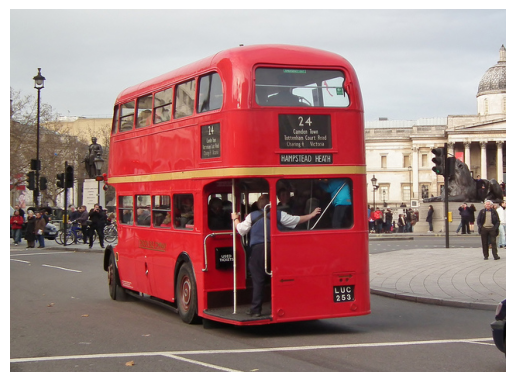

<|endoftext|>A double deck bus the street next to each other in a densely populated city. <|endoftext|><|endoftext|>


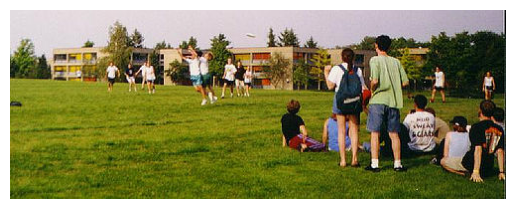

<|endoftext|>A group of young boys playing soccer in the dirt.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


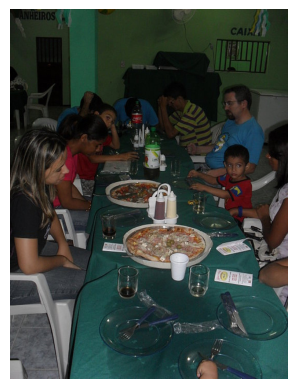

<|endoftext|>A group of people sitting at tables eating soup dishes on a table.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


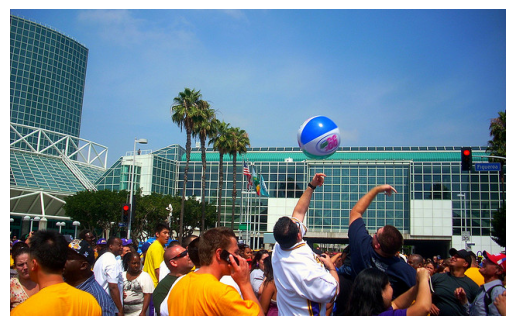

<|endoftext|>A group of a standing group with a soccer ball<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


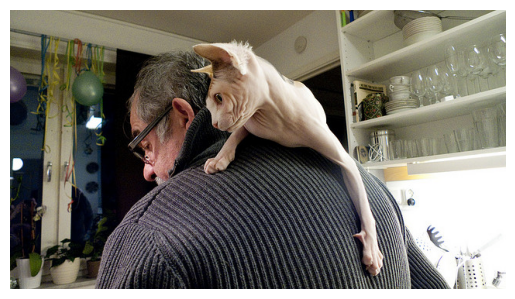

<|endoftext|>A woman and son standing in a parking lot next to a tennis court.<|endoftext|><|endoftext|><|endoftext|><|endoftext|>


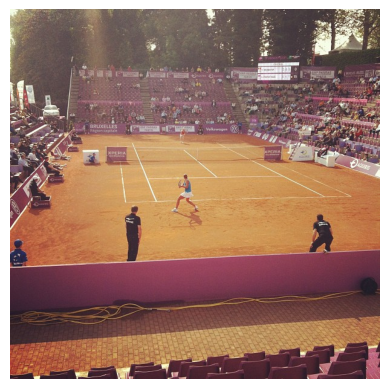

<|endoftext|>A group of children playing tennis on a field.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


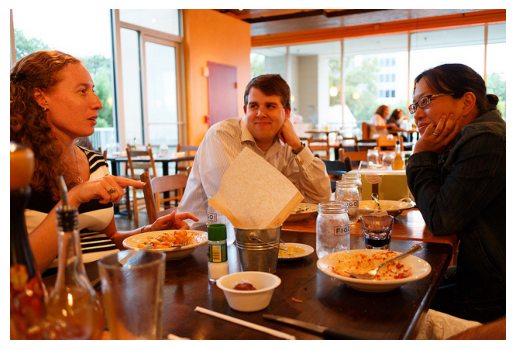

<|endoftext|>A group of people sitting at a dining table.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


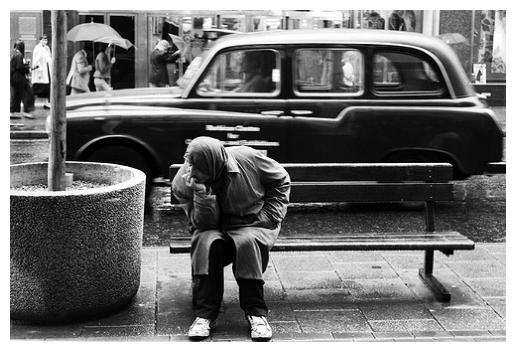

<|endoftext|>A man in a grey vehicle driving in the street below.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


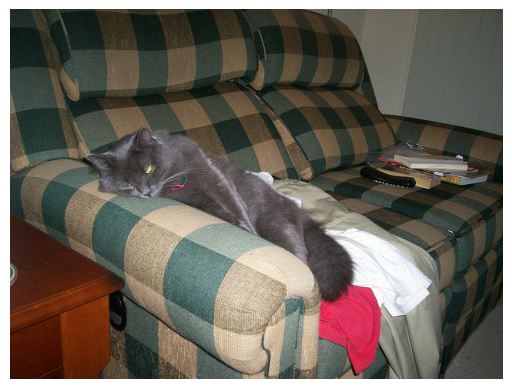

<|endoftext|>A dog lying in a blanket on a couch.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


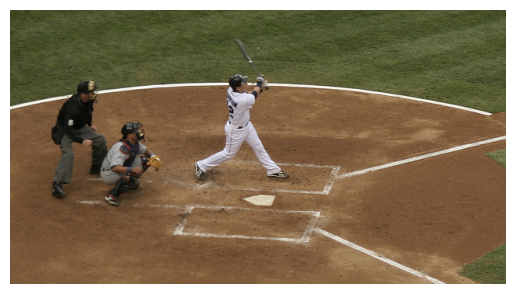

<|endoftext|>A batter at the plate waits for the pitch in front of the pitch<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


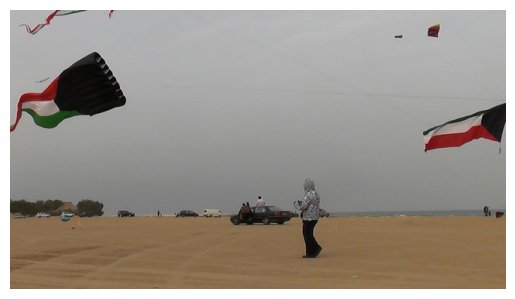

<|endoftext|>A large kite flying kite is flying a kite ball.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


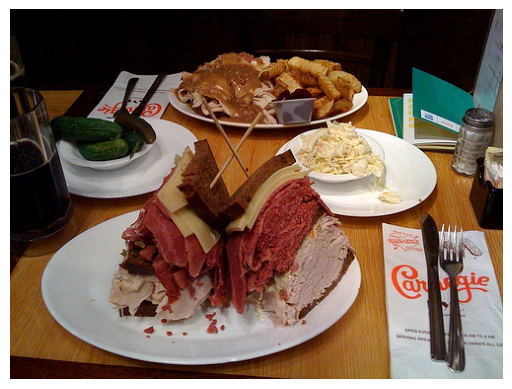

<|endoftext|>A plate of steak, chips and chips is a must for a person.<|endoftext|><|endoftext|><|endoftext|><|endoftext|>


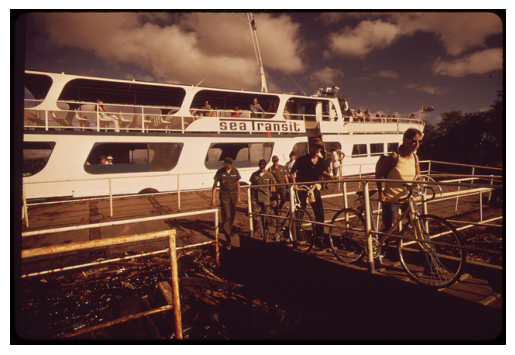

<|endoftext|>A small group of men standing in front of a white statue.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


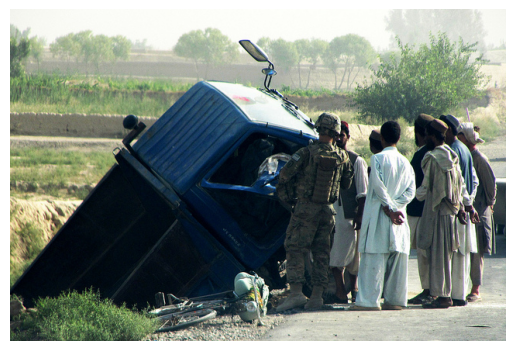

<|endoftext|>A truck parked next to a bus.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


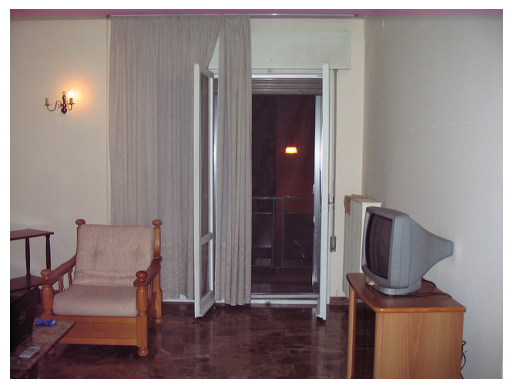

<|endoftext|>A bedite room with a wooden bedite roof on it.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


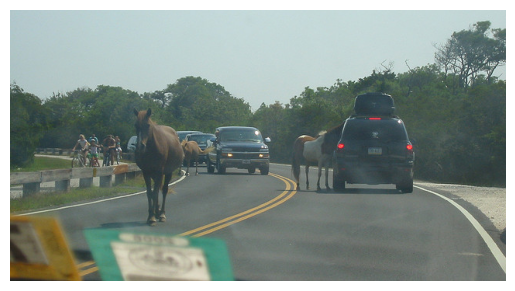

<|endoftext|>A man pulling a horse on a side of a road.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


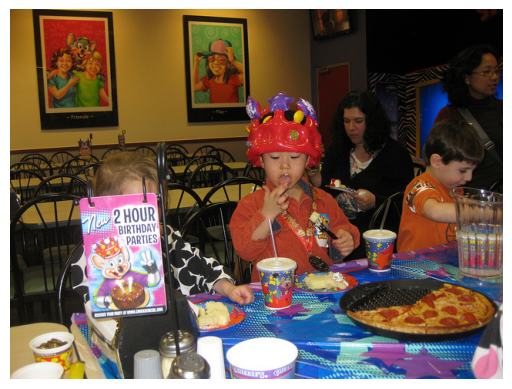

<|endoftext|>A table of table with a variety of desserts and the child looks like they are talking.<|endoftext|>


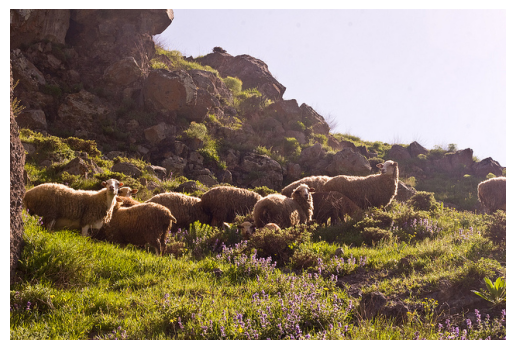

<|endoftext|>A herd of sheep standing in a grassy field.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


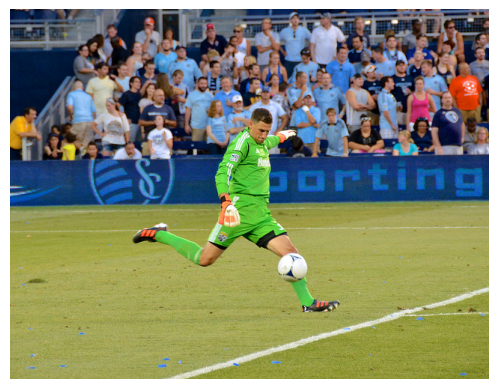

<|endoftext|>A soccer player in a uniform that a person is<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


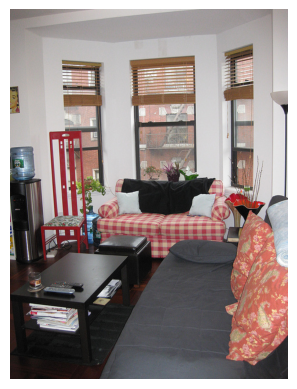

<|endoftext|>A living room is sitting on a living room.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>


In [17]:
_ = model.generate(test_x[:20])

captions = gpt2_tokenizer.batch_decode(_)
imgs = list_of_images[1500:1520]

for i in range(20):
  plt.axis('off')
  plt.imshow(imgs[i])
  plt.show()
  print(captions[i])


In [19]:
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=73d41a920709f57a780b6c5d0994e5f1f2971c91f3f1bb3bcbd9c07f21cbb36a
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [29]:
import evaluate

__ = model.generate(test_x)
three_hundred_captions = gpt2_tokenizer.batch_decode(__)

rouge = evaluate.load('rouge')
bleu = evaluate.load("bleu")
bertscore =  evaluate.load("bertscore")

results_rouge = rouge.compute(predictions=three_hundred_captions,
                           references=random_caps[1500:])

results_bert = bertscore.compute(predictions=three_hundred_captions,
                           references=random_caps[1500:], lang="en")

results_bleu = bleu.compute(predictions=three_hundred_captions,
                           references=random_caps[1500:])

print(results_rouge,results_bert,results_bleu)

{'rouge1': 0.20453097944898113, 'rouge2': 0.04820061843834521, 'rougeL': 0.18645976237420292, 'rougeLsum': 0.18639350130806134} {'precision': [0.7088807821273804, 0.6939949989318848, 0.7219866514205933, 0.6917499303817749, 0.6985853314399719, 0.6935881972312927, 0.7119277715682983, 0.7147536277770996, 0.7041494846343994, 0.6942682862281799, 0.7157409191131592, 0.6926138401031494, 0.7136709690093994, 0.700733482837677, 0.705449104309082, 0.6893479824066162, 0.6885655522346497, 0.6902378797531128, 0.7001540064811707, 0.691165030002594, 0.7185462117195129, 0.7092206478118896, 0.7042312026023865, 0.7003591656684875, 0.6866540908813477, 0.7384907603263855, 0.7363231778144836, 0.6927962303161621, 0.6844887733459473, 0.723782479763031, 0.6884133815765381, 0.6889092326164246, 0.6967250108718872, 0.7022800445556641, 0.7394786477088928, 0.69559645652771, 0.6769231557846069, 0.6810977458953857, 0.7133988738059998, 0.7033294439315796, 0.7209804654121399, 0.6853567361831665, 0.694913387298584, 0.70